In [15]:
from zipline import run_algorithm
from zipline.api import order_target_percent, symbol, schedule_function, date_rules, time_rules
from datetime import datetime
import pytz
import pyfolio as pf


In [16]:
def initialize(context:object):
    """
    Initialize the context for backtesting.
        context: holds all the parameters for the backtesting
    """
    # The ticker symbols of the Dow Jones Industrial    
    dji = [
        "AAPL",
        "AXP",
        "BA",
        "CAT",
        "CSCO",
        "CVX",
        "DIS",
        "DWDP",
        "GS",
        "HD",
        "IBM",
        "INTC",
        "JNJ",
        "JPM",
        "KO",
        "MCD",
        "MMM",
        "MRK",
        "MSFT",
        "NKE",
        "PFE",
        "PG",
        "TRV",
        "UNH",
        "UTX",
        "V",
        "VZ",
        "WBA",
        "WMT",
        "XOM", 
    ]

    # Make a list of symbols from the dfi ticker
    context.universe = [ symbol(s) for s in dji]

    # History window
    context.history_window = 20

    # Size of our portfolio
    context.stocks_to_hold = 10

    # Schedule the daily trading routine for once per month
    schedule_function(handle_data, date_rules.month_start(), time_rules.market_close())


In [17]:
def month_perf(ts):
    """
    Determine the performance
    """ 
    perf = (ts[-1] / ts[0]) - 1
    return perf

In [18]:
def handle_data(context, data):
    """
    Handle the data etc. when a backtest is run
    """

    # Get closing prices for all stocks in the context's universe for the last n days:
    hist = data.history(context.universe, "close", context.history_window, "1d")

    # Create a sorted table of percent returns
    perf_table = hist.apply(month_perf).sort_values(ascending=False)

    # Make a list of stock to BUY (the top n performers)
    buy_list = perf_table[ :context.stocks_to_hold]

    # ... the rest will not be held
    the_rest = perf_table[context.stocks_to_hold: ]

    # Place BUY orders for top N stocks
    for stock, perf in buy_list.iteritems():
        stock_weight = 1 / context.stocks_to_hold

        if data.can_trade(stock):
            order_target_percent(stock, stock_weight)

    # And SELL the rest
    for stock, perf in the_rest.iteritems():
        if data.can_trade(stock):
            order_target_percent(stock, 0.0)
            


In [19]:
def analyze(context, perf):
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    pf.create_returns_tear_sheet(returns, benchmark_rets=None)

Start date,2003-01-02
End date,2018-01-26
Total months,180
,Backtest
Annual return,4.6%
Cumulative returns,98.0%
Annual volatility,17.9%
Sharpe ratio,0.34
Calmar ratio,0.07
Stability,0.06
Max drawdown,-64.6%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,64.56,2007-10-31,2009-03-09,2017-11-30,2632
1,15.40,2003-01-06,2003-03-11,2003-05-12,91
2,10.43,2007-07-19,2007-08-28,2007-10-31,75
3,8.54,2007-01-16,2007-03-05,2007-04-25,72
4,8.20,2005-03-07,2005-04-28,2005-08-03,108


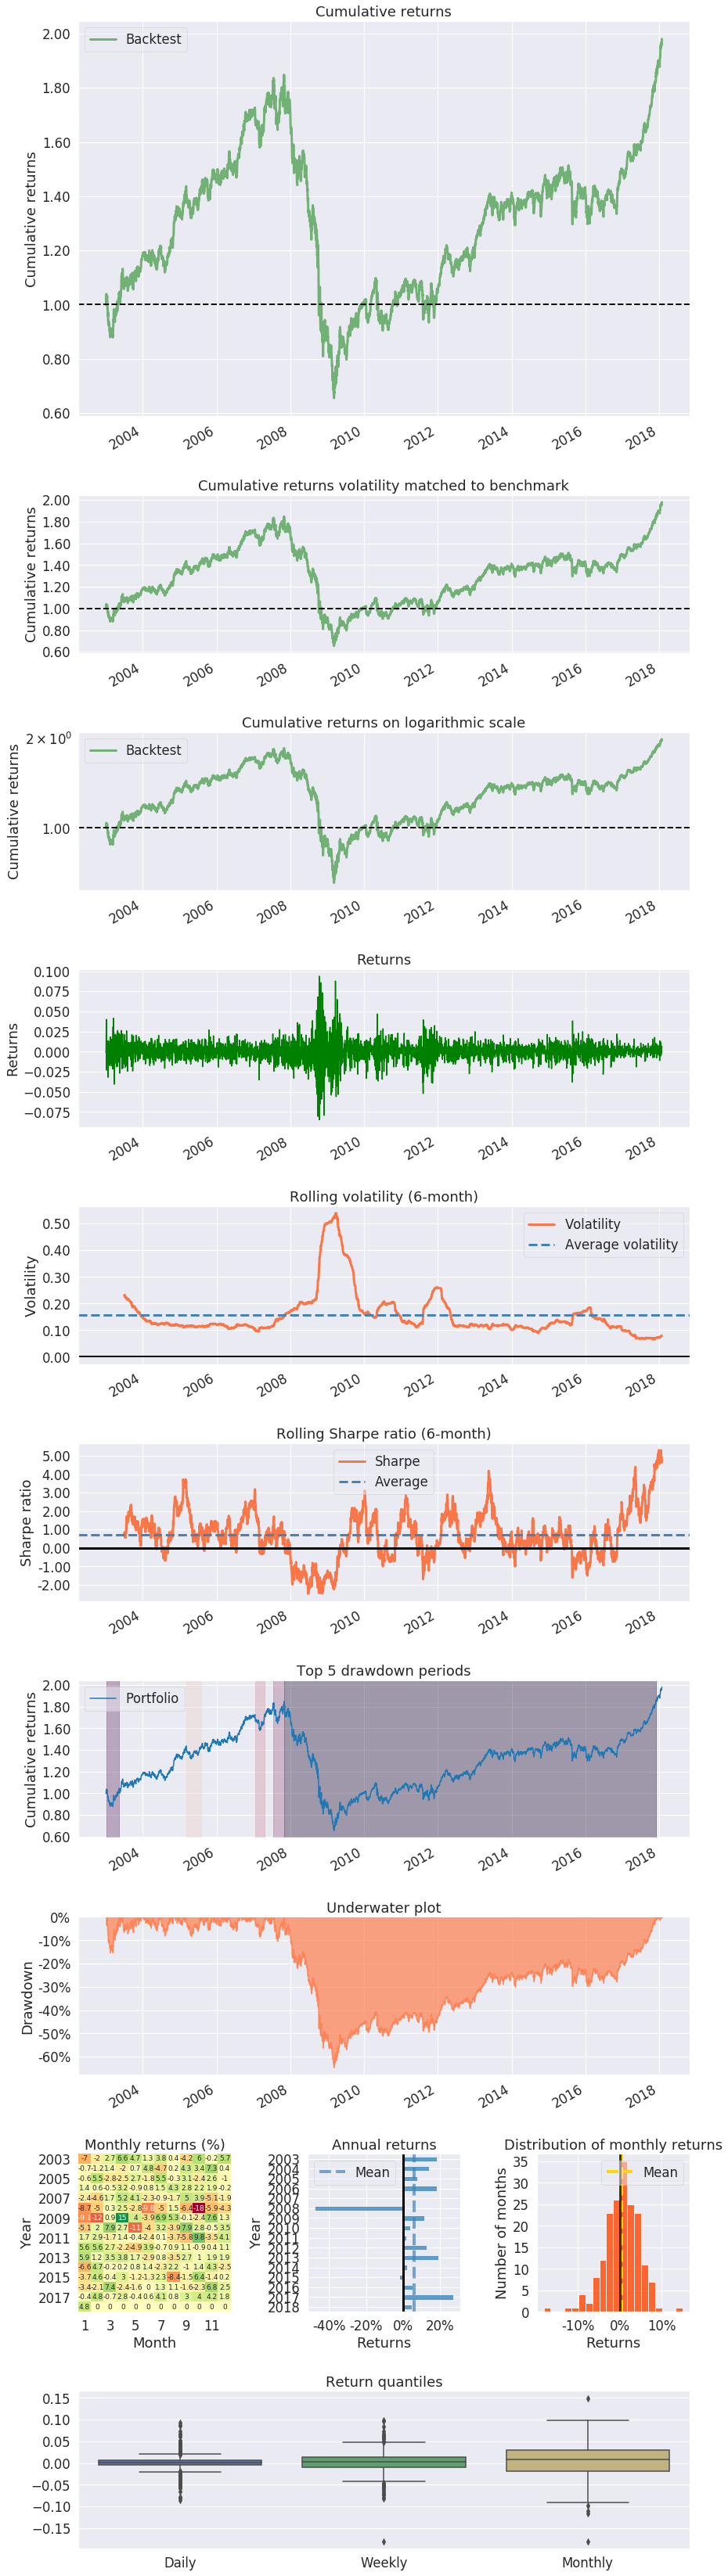

In [24]:
# Run the backtest
#
start = datetime(2003, 1, 1, tzinfo=pytz.UTC)
end = datetime(2018, 1, 26, tzinfo=pytz.UTC)

result = run_algorithm(
    start=start,
    end=end,
    initialize=initialize,
    analyze=analyze,
    handle_data=handle_data,
    capital_base=10000,
    data_frequency='daily',
    bundle='quandl'
)